In [ ]:

# ! python3 -m spacy download en_core_web_sm
import pandas as pd
import numpy as np

import nltk
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('punkt')

import re
import time

# Text Preprocessing
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy

nlp = spacy.load("en_core_web_sm")

# LDA Modeling
from gensim import corpora, models, parsing

! pip install optuna
# LDA Parameter Optimization
import optuna

# Visulization
import matplotlib.pyplot as plt
import seaborn as sns

! pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

import gensim.downloader as api

# Pretrained Model with twitter dataset
word2vec_model = api.load("glove-twitter-25")


The URLs below point to XLSX files containing tweets from 2022 from the following Twitter accounts:
- [@TheBeaverton](https://twitter.com/TheBeaverton)
- [@BillNye](https://twitter.com/BillNye) (Bill Nye)
- [@GeorgeTakei](https://twitter.com/GeorgeTakei) (George Takei)
- [@MeCookieMonster](https://twitter.com/MeCookieMonster) (Cookie Monster)
- [@neiltyson](https://twitter.com/neiltyson) (Neil deGrasse Tyson)
- [@StephenKing](https://twitter.com/StephenKing) (Stephen King)
- [@22_Minutes](https://twitter.com/22_Minutes) (This Hour Has 22 Minutes)

*If you want local copies of these data files, you can download each by Ctrl+clicking (Windows) or Command+clicking (Mac) the links below.*

In [ ]:
beaverton_url = 'https://drive.google.com/uc?export=download&id=173t6vMYcbSED81IOmg0MbhHsrSFSiF21'
billnye_url = 'https://drive.google.com/uc?export=download&id=1w1Xm-TQfcPfGICM_8_LQiWSqzf8WUk8N'
georgetakei_url = 'https://drive.google.com/uc?export=download&id=1_Ck9S2aW9cBQQrqoTiNLRmvRu4WvPn8y'
cookiemonster_url = 'https://drive.google.com/uc?export=download&id=10Av-HVklZA4Su3TcvSpxU6nS8At9mJ05'
neiltyson_url = 'https://drive.google.com/uc?export=download&id=1GSKxxldXe--HE4gSYAEn2ip2vS4bXKMM'
stephenking_url = 'https://drive.google.com/uc?export=download&id=1Oq2pUCv0d7x4tDKX1E-3hgdSAuXcZtVU'
twentytwo_minutes_url = 'https://drive.google.com/uc?export=download&id=1B2zwAJYdw_9skXAFbn7QIs6uyIikje5W'

## Read Data

In [ ]:
def read_twitter_data(url)
    return pd.read_excel(url, engine='openpyxl')

In [ ]:
data = read_twitter_data(billnye_url)
data.head()

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,tweet-id,tweet-text,tweet-author,tweet-timestamp-date
0,1,"Happy Twosday, people(s). That’s right, it’s 2...",Bill Nye,2022-02-22
1,2,Dr. King would be 93 years old this week. The ...,Bill Nye,2022-01-17
2,3,Happy Isaac Newton’s Birthday James Webb Space...,Bill Nye,2021-12-25
3,4,"Please, consider the following… my new VR Spac...",Bill Nye,2021-12-14
4,5,Winter tornadoes… warm winter in the south & c...,Bill Nye,2021-12-12


## Text Preprocessing
The given code is a text preprocessing pipeline designed to clean and prepare raw text data for Natural Language Processing (NLP) tasks. This pipeline removes noise and standardizes text for further analysis, such as topic modeling (e.g., LDA), sentiment analysis, or machine learning models.

1.	Tokenization & Lowercasing
	  - The input text is converted to lowercase to ensure case-insensitive processing.
	  - All punctuation is removed using regular expressions (re.sub).
2.	Stop Word Removal
	- 	Common stop words (e.g., “the”, “is”, “and”) that do not contribute meaningful information are removed.
3.	Lemmatization
	- 	Words are reduced to their base (root) form using the WordNet Lemmatizer, which helps unify different word forms.
	- 	Example: "running" → "run", "better" → "good".
4.	Filtering Verbs and Nouns
	- 	The function leave_verb_noun(text) retains only nouns and verbs since they are often the most informative parts of a sentence.
5.	Removing Numbers & Short Words
	- 	Any numbers in the text are removed.
	- 	Short words (length ≤ 2) are filtered out, as they often do not carry meaningful information.

In [ ]:
def leave_verb_noun(text):
    doc = nlp(' '.join(text).lower())
    words = [token.lemma_ for token in doc if token.pos_ in ["NOUN", "VERB"] and not token.is_stop and not token.is_punct]
    return words


def text_prep(text):
    # Remove punctuation / change to lower case
    text = re.sub(r'[^\w\s]', '', str.lower(text))

    # Remove stop words
    clean_text = parsing.preprocessing.remove_stopwords(text)


    # lemmatization
    lemmatizer = WordNetLemmatizer()
    lem_text = [lemmatizer.lemmatize(word) for word in word_tokenize(clean_text)]

    # Leave Verb and Noun Only
    VN_text = leave_verb_noun(lem_text)

    # Remove Numbers & Short word
    prep_text = [re.sub(r'\d+', '', word) for word in VN_text if len(word) > 2]

    return prep_text

print('Before: ', data['tweet-text'][3], sep='\n')
print('After: ', text_prep(data['tweet-text'][3]), sep='\n')


Before: 
Please, consider the following… my new VR Space Lab is available now on Amazon – and nominated for Toy of the Year!  85 piece set, with hands on experiments and VR goggles to step into my spaceship in virtual reality. 
After: 
['consider', 'follow', 'space', 'year', 'piece', 'set', 'hand', 'experiment', 'goggle', 'step', 'spaceship', 'reality']


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
data['prep-tweet-text'] = data['tweet-text'].apply(lambda x:text_prep(x))

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### LDA Model Preprocess

Bag of Words Format Transform

In [ ]:
texts = data['prep-tweet-text']
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Optimized LDA Model Parameters

Using [Optuna](https://optuna.org/) to make parameters trials to find the best parameters set.

Parameters Select:
| **Parameter**   | **Description**                           | **Range**   | **Impact**  |
|---------------|-----------------------------------|-----------|------------|
| `num_topics`  | Number of topics in LDA         | 2 - 10    | Controls topic granularity |
| `alpha`       | Document-topic distribution smoothing | 0.01 - 1.0 | Higher values distribute topics more evenly across documents |
| `passes`      | Number of training passes       | 5 - 20    | More passes improve learning but increase training time |
| `iteration`   | Iterations per pass             | 50 - 200  | More iterations improve model quality but slow down training |


#### **Objective Function Calculation**
The objective function is designed to **maximize coherence score** while **minimizing perplexity and training time**:

$
\text{objective value} = (1 - \text{coherence score}) * 0.7 + \text{normalized perplexity} * \lambda_{\text{perplexity}} + \text{normalized train time} * \lambda{\text{time}}
$

#### **Explanation of Terms:**
- **Coherence Score (`coherence_score`)** → Higher values indicate better topic quality.
- **Perplexity (`normalized_perplexity`)** → Lower values indicate better topic modeling.
- **Training Time (`normalized_train_time`)** → Lower values indicate faster training efficiency.
- **Weights:**
  - $0.7$ → Prioritizes coherence score.
  - $λ_{\text{perplexity}}$ → Controls the weight of perplexity.
  - $λ_{\text{time}}$ → Controls the weight of training time.

#### **Target:**
- **Minimize `objective_value`** to find the best hyperparameter combination.


In [ ]:
# Normalize  Perplexity & Train_time
min_perplexity, max_perplexity = 100, 2000

min_train_time, max_train_time = 1, 100


def objective(trial):
    num_topics = trial.suggest_int('num_topics', 3, 7)

    # Tweets are short articel, we prefer alpha not over 1
    alpha = trial.suggest_float('alpha', 0.01, 1.0, log=True)

    passes = trial.suggest_int('passes', 5, 20)

    iteration = trial.suggest_int('iteration', 50, 200)

    start_time = time.time()

    lda_model = models.LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=num_topics,
        alpha=alpha,
        eta='auto',
        passes=passes,
        iterations=iteration,
        random_state=42
    )

    # Multi-Objective Values
    # 1. Calcualte Coherence Score
    coherence_model = models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_score = coherence_model.get_coherence()

    # 2. Perplexity Score
    perplexity = lda_model.log_perplexity(corpus)
    normalized_perplexity = (perplexity - min_perplexity) / (max_perplexity - min_perplexity)


    # 3. Time
    train_time = time.time() - start_time
    normalized_train_time = (train_time - min_train_time) / (max_train_time - min_train_time)


    # Create Objective Function to implement Maximize Coherence Value & Minimize Training Time
    _lambda_perplexity = 0.2
    _lambda_time = 0.05

    objective_value = (1 - coherence_score) * 0.7 + normalized_perplexity * _lambda_perplexity + normalized_train_time * _lambda_time

    # Minimum objective_value
    return objective_value

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Start Optimizing

In [ ]:
# Remove note to view the optimizing process
optuna.logging.set_verbosity(optuna.logging.WARNING)

# Trial Params Defined
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40, show_progress_bar=True)

# Show Result
print("Best Parameters:")
print(study.best_params)

print("Best Objective Value:", study.best_value)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/40 [00:00<?, ?it/s]

Best Parameters:
{'num_topics': 5, 'alpha': 0.12392086714794368, 'passes': 14, 'iteration': 116}
Best Objective Value: 0.3519463976624172


**Parameters Trial Visulization**

This chart provide the parameters values set in different trail. It can help better visualize which combination of params can provides better result with objective value. In this case, the lower objective value provide better consequence result.

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### **Model Create with Best Params Set**

In [ ]:
best_params = study.best_params

# Train LDA model with optimized parameters
best_lda_model = models.LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=best_params['num_topics'],
    alpha=best_params['alpha'],
    eta='auto',
    passes=best_params['passes'],
    iterations=best_params['iteration'],
    random_state=42
)

/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



#### **Top Keywords Selection**


In [ ]:
lambda_value = 0.6
keywords = []

for topic_id in range(best_lda_model.num_topics):
    topic_words = best_lda_model.show_topic(topic_id, topn=10)
    sorted_words = sorted(topic_words, key=lambda x: x[1] * lambda_value, reverse=True)
    keywords.append([word for word, _ in sorted_words])
    print(f" Topic {topic_id}:")
    print(", ".join([word for word, _ in sorted_words]))

 Topic 0:
change, people, exploreplanet, climate, question, think, life, earth, send, picture
 Topic 1:
change, climate, let, work, world, earth, vote, need, water, electricity
 Topic 2:
science, look, space, let, thing, day, way, world, today, know
 Topic 3:
today, year, space, climate, change, time, world, people, honor, day
 Topic 4:
day, today, science, year, work, earth, let, world, spacex, join


/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



/usr/local/lib/python3.11/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.




Topic Distances (Euclidean):
Distance between Topic 0 and Topic 1: 1.217
Distance between Topic 0 and Topic 2: 1.151
Distance between Topic 0 and Topic 3: 1.286
Distance between Topic 0 and Topic 4: 1.717
Distance between Topic 1 and Topic 2: 1.441
Distance between Topic 1 and Topic 3: 0.928
Distance between Topic 1 and Topic 4: 1.180
Distance between Topic 2 and Topic 3: 0.674
Distance between Topic 2 and Topic 4: 0.950
Distance between Topic 3 and Topic 4: 0.430


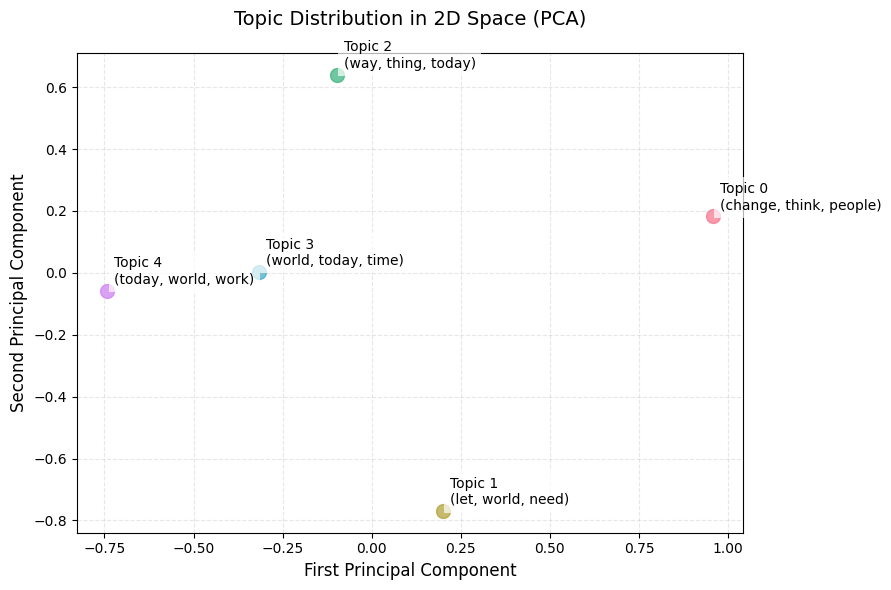


Explained variance ratio: [0.48411124 0.31103756]
Total explained variance: 0.795


In [ ]:

# Get topic vectors and representative words
topic_vectors = []
topic_words = []
topic_representative_words = []

for topic_id in range(best_lda_model.num_topics):
    # Get top 10 words for each topic
    words = [word for word, _ in best_lda_model.show_topic(topic_id)]
    word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]

    if word_vectors:
        # Calculate mean vector for the topic
        topic_vectors.append(np.mean(word_vectors, axis=0))

        # Find most representative words using cosine similarity
        similarity_matrix = cosine_similarity(word_vectors)
        avg_similarities = np.mean(similarity_matrix, axis=1)

        # Get top 3 most representative words
        top_3_indices = np.argsort(avg_similarities)[-3:][::-1]
        representative_words = [words[idx] for idx in top_3_indices]
        topic_representative_words.append(representative_words)
    else:
        topic_vectors.append(np.zeros(word2vec_model.vector_size))
        topic_representative_words.append(['N/A', 'N/A', 'N/A'])

# Use PCA for dimensionality reduction
pca = PCA(n_components=2)
topic_coords = pca.fit_transform(topic_vectors)

# Create visualization
plt.figure(figsize=(9, 6))

# Set color palette
colors = sns.color_palette("husl", n_colors=len(topic_vectors))

# Plot scatter points
for i, (x, y) in enumerate(topic_coords):
    plt.scatter(x, y, c=[colors[i]], s=100, alpha=0.7)

    # Add topic labels with representative words
    top_words = ', '.join(topic_representative_words[i])  # Using the most representative words
    plt.annotate(f'Topic {i}\n({top_words})',
                (x, y),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=10,
                bbox=dict(facecolor='white',
                         edgecolor='none',
                         alpha=0.7))

plt.title('Topic Distribution in 2D Space (PCA)', fontsize=14, pad=20)
plt.xlabel('First Principal Component', fontsize=12)
plt.ylabel('Second Principal Component', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()

# Calculate and display topic distances
print("\nTopic Distances (Euclidean):")
for i in range(len(topic_coords)):
    for j in range(i+1, len(topic_coords)):
        dist = np.linalg.norm(topic_coords[i] - topic_coords[j])
        print(f"Distance between Topic {i} and Topic {j}: {dist:.3f}")

plt.show()

# Display PCA explained variance
explained_variance_ratio = pca.explained_variance_ratio_
print(f"\nExplained variance ratio: {explained_variance_ratio}")
print(f"Total explained variance: {sum(explained_variance_ratio):.3f}")